## Radial velocity animation - MITgcm output vs lab experiment 

### Development of comparison metrics

||MITgcm model|Lab experiment|
|:-:|:-:|:-:|
|**Date**|01-Jul-20| 19-Dec-20 |
|**Run**| BF4_from_PIV_two_can/run01| T14|
|**f (s$^{-1}$)**| 0.7 |0.7 to 0.74 to 0.78|
|**Density profile**|From interp. measurements|From interp. measurements|
|**N at sb depth (s$^{-1}$)**|1.86|1.86|
|**Max U (cm s$^{-1}$)** |||


In [118]:
import cmocean as cmo
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
import scipy.interpolate 
import scipy.io as sio
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import sys
sys.path.append('../../lab/Conduino/scripts')
import conduino_tools as ctools

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Functions

In [217]:
def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u, v

def rotate(x_comp, y_comp, angle):
    '''Input:
        x_comp:: x component of vector
        y_comp:: y component of vector
       angle:: in radians.
       Returns:
       Rotated componets of vector x_rot and y_rot'''
    x_rot = x_comp*np.cos(angle)-(y_comp)*np.sin(angle)
    y_rot = x_comp*np.sin(angle)+(y_comp)*np.cos(angle)
    return(x_rot, y_rot)

def trans_polar(r,th,r0,th0):
    rprime = (r**2+r0**2+2*r*r0*np.cos(th0-th))**0.5
    thprime = np.arccos((r*np.cos(th)+r0*np.cos(th0))/rprime)
    return(rprime,thprime)

def get_field(varname, filepath):
    '''
    file:: str, path to file
    name:: str, variable name (eg 'typevector_filtered', 'velocity_magnitude', 'x','y','u_filtered', 'v_filtered', etc.)
    '''
    mat = sio.loadmat(filepath, squeeze_me=True)
    var = mat[varname]
    return(var)

def get_mask(filepath, fr=0):
    '''Get the mask from a PIV mat file.'''
    mat = sio.loadmat(filepath, squeeze_me=True)
    mask_PIV = np.ma.masked_values(mat['typevector_filtered'][0],0)
    mask = np.ma.getmask(mask_PIV)
    return(mask)

def get_insert_bathy(angle, H = 0.092):
    ''' Get the bathymetry of the canyon insert and x,y coordinates rotated by an angle
    
    INPUT
    angle:: float, angle in radians, positive angle rotates counterclockwise
    H:: float, max depth of water column in meters
    
    RETURNS
    xIns_rot, yIns_rot, x and y coordinates rotated by angle (2D arrays)
    depth_ins, 2D array with depth values'''
    
    insert_file = '/ocean/kramosmu/Building_canyon/BuildCanyon/Bathymetry/tank/BathyInsert03.nc'
    H = 0.092 # m, max water level

    with Dataset(insert_file, 'r') as nbl:
        Xins = nbl.variables['X'][:]
        Yins = nbl.variables['Y'][:]
        depth_ins = (nbl.variables['Bathymetry'][:])-H

    xIns_rot = Xins*np.cos(angle)-(Yins)*np.sin(angle)
    yIns_rot = Xins*np.sin(angle)+(Yins)*np.cos(angle)
    return(xIns_rot, yIns_rot, depth_ins)

def get_plot_data(fr, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr,y,x)
    x_ma = 100*np.ma.masked_array(x[fr], mask=mask)
    y_ma = 100*np.ma.masked_array(y[fr], mask=mask)
    u_ma = 100*np.ma.masked_array(u[fr], mask=mask)
    v_ma = 100*np.ma.masked_array(v[fr], mask=mask)
    spd_ma =100* np.ma.masked_array(spd[fr],mask=mask)

    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

def get_plot_data_mean(fr_slice, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr_slice,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr_slice,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr_slice,y,x)
     
    x_ma = 100*np.ma.masked_array(np.mean(x[fr_slice],0), mask=mask)
    y_ma = 100*np.ma.masked_array(np.mean(y[fr_slice],0), mask=mask)
    u_ma = 100*np.ma.masked_array(np.mean(u[fr_slice],0), mask=mask)
    v_ma = 100*np.ma.masked_array(np.mean(v[fr_slice],0), mask=mask)
    spd_ma =100*np.ma.masked_array(np.mean(spd[fr_slice],0),mask=mask)
    
    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

def plot_lab_rad_vel(ax0,ax1,ax2,max_spd, min_spd,cbar_ticks,fr,mode='snap',nt=0):
  
    # data for frame 
    if mode =='snap':
        x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data(fr, filepath1, angle, mask1)
        x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data(fr, filepath2, angle, mask2)
        x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data(fr, filepath3, angle, mask3)
    elif mode =='avg':
        fr_slice = slice(fr,fr+nt)
        x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data_mean(fr_slice, filepath1, angle, mask1)
        x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data_mean(fr_slice, filepath2, angle, mask2)
        x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data_mean(fr_slice, filepath3, angle, mask3)
    else:
        assert(mode!='snap'and mode!='avg'),"%s is not a valid mode" %mode
    
    r1 = ((x_ma1+5)**2+(y_ma1-np.min(y_ma1))**2)**0.5
    th1 = np.arctan((y_ma1-np.min(y_ma1))/(x_ma1+5))
    ur1 = (np.cos(th1)*u_ma1)+(np.sin(th1)*v_ma1)
    uth1 = ((r1*np.cos(th1)*v_ma1)-(r1*np.sin(th1)*u_ma1))/(r1**2)

    r2 = ((x_ma2+5)**2+(y_ma2-np.min(y_ma2))**2)**0.5
    th2 = np.arctan((y_ma2-np.min(y_ma2))/(x_ma2+5))
    ur2 = (np.cos(th2)*u_ma2)+(np.sin(th2)*v_ma2)
    uth2 = ((r2*np.cos(th2)*v_ma2)-(r2*np.sin(th2)*u_ma2))/(r2**2)

    r3 = ((x_ma3+5)**2+(y_ma3-np.min(y_ma3))**2)**0.5
    th3 = np.arctan((y_ma3-np.min(y_ma3))/(x_ma3+5))
    ur3 = (np.cos(th3)*u_ma3)+(np.sin(th3)*v_ma3)
    uth3 = ((r3*np.cos(th3)*v_ma3)-(r3*np.sin(th3)*u_ma3))/(r3**2)

    # plot data 1
    cf = ax0.contourf(th1,r1,ur1,30,
                      cmap=cmo.cm.balance, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    cbar_ax = fig.add_axes([1.02, 0.26, 0.02, 0.7])
    cb = plt.colorbar(cf, cax=cbar_ax, extend='both',ticks=cbar_ticks,format='%.1f')
    cb.ax.yaxis.set_tick_params(pad=1)
    cb.ax.set_title(r'$u_r$/ cms$^{-1}$')
    
    qv = ax0.quiver(th1[::2,::2],r1[::2,::2],
                    U1[::2,::2],V1[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
    ur_d1_st1 = np.nanmean(ur1[d1_lst_1[0]-1:d1_lst_1[0]+1,d1_lst_1[1]-1:d1_lst_1[1]+1])
    ur_d1_st2 = np.nanmean(ur1[d1_lst_2[0]-1:d1_lst_2[0]+1,d1_lst_2[1]-1:d1_lst_2[1]+1])
    ur_d1_st3 = np.nanmean(ur1[d1_lst_3[0]-1:d1_lst_3[0]+1,d1_lst_3[1]-1:d1_lst_3[1]+1])
    ur_d1_st4 = np.nanmean(ur1[d1_lst_4[0]-1:d1_lst_4[0]+1,d1_lst_4[1]-1:d1_lst_4[1]+1])
    
    ax0.plot(th1[d1_lst_1[0],d1_lst_1[1]],r1[d1_lst_1[0],d1_lst_1[1]],'.',color='red')
    ax0.plot(th1[d1_lst_2[0],d1_lst_2[1]],r1[d1_lst_2[0],d1_lst_2[1]],'.',color='navy')
    ax0.plot(th1[d1_lst_3[0],d1_lst_3[1]],r1[d1_lst_3[0],d1_lst_3[1]],'.',color='coral')
    ax0.plot(th1[d1_lst_4[0],d1_lst_4[1]],r1[d1_lst_4[0],d1_lst_4[1]],'.',color='lightblue')
     
    # plot data 2
    cf = ax1.contourf(th2,r2,ur2,30,
                      cmap=cmo.cm.balance, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays

    qv = ax1.quiver(th2[::2,::2],r2[::2,::2],
                    U2[::2,::2],V2[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
    ur_d2_st1 = np.nanmean(ur1[d2_lst_1[0]-1:d2_lst_1[0]+1,d2_lst_1[1]-1:d2_lst_1[1]+1])
    ur_d2_st2 = np.nanmean(ur1[d2_lst_2[0]-1:d2_lst_2[0]+1,d2_lst_2[1]-1:d2_lst_2[1]+1])
    ur_d2_st3 = np.nanmean(ur1[d2_lst_3[0]-1:d2_lst_3[0]+1,d2_lst_3[1]-1:d2_lst_3[1]+1])
    ur_d2_st4 = np.nanmean(ur1[d2_lst_4[0]-1:d2_lst_4[0]+1,d2_lst_4[1]-1:d2_lst_4[1]+1])
 
    ax1.plot(th2[d2_lst_1[0],d2_lst_1[1]],r2[d2_lst_1[0],d2_lst_1[1]],'.',color='red')
    ax1.plot(th2[d2_lst_2[0],d2_lst_2[1]],r2[d2_lst_2[0],d2_lst_2[1]],'.',color='navy')
    ax1.plot(th2[d2_lst_3[0],d2_lst_3[1]],r2[d2_lst_3[0],d2_lst_3[1]],'.',color='coral')
    ax1.plot(th2[d2_lst_4[0],d2_lst_4[1]],r2[d2_lst_4[0],d2_lst_4[1]],'.',color='lightblue')
    
    # plot data 3
    cf = ax2.contourf(th3,r3,ur3,30,
                      cmap=cmo.cm.balance, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays

    qv = ax2.quiver(th3[::2,::2],r3[::2,::2],
                    U3[::2,::2],V3[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
    ur_d3_st1 = np.nanmean(ur1[d3_lst_1[0]-1:d3_lst_1[0]+1,d3_lst_1[1]-1:d3_lst_1[1]+1])
    ur_d3_st2 = np.nanmean(ur1[d3_lst_2[0]-1:d3_lst_2[0]+1,d3_lst_2[1]-1:d3_lst_2[1]+1])
    ur_d3_st3 = np.nanmean(ur1[d3_lst_3[0]-1:d3_lst_3[0]+1,d3_lst_3[1]-1:d3_lst_3[1]+1])
    ur_d3_st4 = np.nanmean(ur1[d3_lst_4[0]-1:d3_lst_4[0]+1,d3_lst_4[1]-1:d3_lst_4[1]+1])
    
    ax2.plot(th3[d3_lst_1[0],d3_lst_1[1]],r3[d3_lst_1[0],d3_lst_1[1]],'.',color='red')
    ax2.plot(th3[d3_lst_2[0],d3_lst_2[1]],r3[d3_lst_2[0],d3_lst_2[1]],'.',color='navy')
    ax2.plot(th3[d3_lst_3[0],d3_lst_3[1]],r3[d3_lst_3[0],d3_lst_3[1]],'.',color='coral')
    ax2.plot(th3[d3_lst_4[0],d3_lst_4[1]],r3[d3_lst_4[0],d3_lst_4[1]],'.',color='lightblue')
  
    ax0.text(0.05,.7,'Depth = 3.3 cm',transform=ax0.transAxes)
    ax1.text(0.05,.7,'Depth = 4.5 cm',transform=ax1.transAxes)
    ax2.text(0.05,.7,'Depth = 6.0 cm',transform=ax2.transAxes)
    #ax0.text(-0.1,1.2,'Radial velocity at %1.1f s' %(((fr/5)+((fr+nt)/5))/2),transform=ax0.transAxes)
    ax0.set_rlim(10,28)
    ax1.set_rlim(10,28)
    ax2.set_rlim(10,28)    
    ax0.set_thetalim(0*np.pi/180,90*np.pi/180)
    ax1.set_thetalim(0*np.pi/180,90*np.pi/180)
    ax2.set_thetalim(0*np.pi/180,90*np.pi/180)
    #ax0.set_aspect(1)
    #ax1.set_aspect(1)
    #ax2.set_aspect(1)
    return(ax0, ax1, ax2, ur_d1_st1, ur_d1_st2, ur_d1_st3, ur_d1_st4, ur_d2_st1, ur_d2_st2, ur_d2_st3, ur_d2_st4, ur_d3_st1, ur_d3_st2, ur_d3_st3, ur_d3_st4)

def plot_ur(ax,times,ur1m,ur2m,ur3m,ur4m,ur1l,ur2l,ur3l,ur4l,max_time=71):
    ax.axhline(0,color='0.6')
    ax.plot(times, ur1m, '-r')
    ax.plot(times, ur1l, ':r', alpha=1)
    ax.plot(times, ur2m,'-',color='navy')
    ax.plot(times, ur2l,':',color='navy', alpha=1)
    ax.plot(times, ur3m,'-', color='coral')
    ax.plot(times, ur3l,':', color='coral', alpha=1)
    ax.plot(times, ur4m,'-',color='lightblue')
    ax.plot(times, ur4l,':',color='lightblue', alpha=1)
    ax.set_xlim(0,max_time)
    ax.set_ylim(-0.6,0.6)
    ax.set_xlabel('time / s', labelpad=0)
    return(ax)
    
    


In [216]:
def plot_model_rad_vel(ax0,ax1,ax2, tt, thmesh, rmesh, nz1, nz2, nz3, vmin, vmax, cbar_ticks):
    th_offset = (-np.pi*155)/180
    # depth nz1 cm
    thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz1,:,:].data,state.V[tt,nz1,:,:].data)
    thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz1,:,:]))
    rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz1,:,:]))

    ux = rvel*np.cos(thmesh+th_offset)-rmesh*np.sin(thmesh+th_offset)*(-thvel/(rmesh))# minus is MITgcm convention
    uy = rvel*np.sin(thmesh+th_offset)+rmesh*np.cos(thmesh+th_offset)*(-thvel/(rmesh)) 
    U = ux / np.sqrt(ux**2 + uy**2);
    V = uy / np.sqrt(ux**2 + uy**2);
    
    pcm1 = ax0.contourf(Th,R*100,1E2*rvel,30,cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    #cbar_ax = fig.add_axes([0.05, 0.2, 0.016, 0.55])
    #cb = plt.colorbar(pcm1, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
    #cb.ax.yaxis.set_tick_params(pad=1)
    #cb.set_label(r'$u_{r}$ / cms$^{-1}$')
    ax0.contour(Th,R*100,grid.Depth.data,levels=[0.033],colors='k')
    qv = ax0.quiver(thmesh[::5,::5],rmesh[::5,::5]*100,
                    U[::5,::5],V[::5,::5],scale=30, 
                    color='k', units='width',pivot='middle')
    ur_d1_st1 = 1E2*rvel[d1_mst_1[1],d1_mst_1[0]]
    ur_d1_st2 = 1E2*rvel[d1_mst_2[1],d1_mst_2[0]]
    ur_d1_st3 = 1E2*rvel[d1_mst_3[1],d1_mst_3[0]]
    ur_d1_st4 = 1E2*rvel[d1_mst_4[1],d1_mst_4[0]]
    
    ax0.plot(thmesh[d1_mst_1[1],d1_mst_1[0]],rmesh[d1_mst_1[1],d1_mst_1[0]]*100,'.',color='red')
    ax0.plot(thmesh[d1_mst_2[1],d1_mst_2[0]],rmesh[d1_mst_2[1],d1_mst_2[0]]*100,'.',color='navy')
    ax0.plot(thmesh[d1_mst_3[1],d1_mst_3[0]],rmesh[d1_mst_3[1],d1_mst_3[0]]*100,'.',color='coral')
    ax0.plot(thmesh[d1_mst_4[1],d1_mst_4[0]],rmesh[d1_mst_4[1],d1_mst_4[0]]*100,'.',color='lightblue')
        
    # depth 4.5 cm
    thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz2,:,:].data,state.V[tt,nz2,:,:].data)
    thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz2,:,:]))
    rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz2,:,:]))

    ux = rvel*np.cos(thmesh+th_offset)-rmesh*np.sin(thmesh+th_offset)*(-thvel/(rmesh))# minus is MITgcm convention
    uy = rvel*np.sin(thmesh+th_offset)+rmesh*np.cos(thmesh+th_offset)*(-thvel/(rmesh)) 
    U = ux / np.sqrt(ux**2 + uy**2);
    V = uy / np.sqrt(ux**2 + uy**2);
   
    pcm2 = ax1.contourf(Th,R*100,1E2*rvel,30,cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    ax1.contour(Th,R*100,grid.Depth.data,levels=[0.045],colors='k')
    qv = ax1.quiver(thmesh[::5,::5],rmesh[::5,::5]*100,
                    U[::5,::5],V[::5,::5],scale=30, 
                    color='k', units='width',pivot='middle')
    
    ur_d2_st1 = 1E2*rvel[d2_mst_1[1],d2_mst_1[0]]
    ur_d2_st2 = 1E2*rvel[d2_mst_2[1],d2_mst_2[0]]
    ur_d2_st3 = 1E2*rvel[d2_mst_3[1],d2_mst_3[0]]
    ur_d2_st4 = 1E2*rvel[d2_mst_4[1],d2_mst_4[0]]
    
    ax1.plot(thmesh[d2_mst_1[1],d2_mst_1[0]],rmesh[d2_mst_1[1],d2_mst_1[0]]*100,'.',color='red')
    ax1.plot(thmesh[d2_mst_2[1],d2_mst_2[0]],rmesh[d2_mst_2[1],d2_mst_2[0]]*100,'.',color='navy')
    ax1.plot(thmesh[d2_mst_3[1],d2_mst_3[0]],rmesh[d2_mst_3[1],d2_mst_3[0]]*100,'.',color='coral')
    ax1.plot(thmesh[d2_mst_4[1],d2_mst_4[0]],rmesh[d2_mst_4[1],d2_mst_4[0]]*100,'.',color='lightblue')
  
    # depth 6.0 cm
    thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz3,:,:].data,state.V[tt,nz3,:,:].data)
    thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz3,:,:]))
    rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz3,:,:]))

    ux = rvel*np.cos(thmesh+th_offset)-rmesh*np.sin(thmesh+th_offset)*(-thvel/(rmesh))# minus is MITgcm convention
    uy = rvel*np.sin(thmesh+th_offset)+rmesh*np.cos(thmesh+th_offset)*(-thvel/(rmesh)) 
    U = ux / np.sqrt(ux**2 + uy**2);
    V = uy / np.sqrt(ux**2 + uy**2);
   
    pcm3 = ax2.contourf(Th,R*100,1E2*rvel,30,cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    ax2.contour(Th,R*100,grid.Depth.data,levels=[0.06],colors='k')
    qv = ax2.quiver(thmesh[::5,::5],rmesh[::5,::5]*100,
                    U[::5,::5],V[::5,::5],scale=30, 
                    color='k', units='width',pivot='middle')
    
    ur_d3_st1 = 1E2*rvel[d3_mst_1[1],d3_mst_1[0]]
    ur_d3_st2 = 1E2*rvel[d3_mst_2[1],d3_mst_2[0]]
    ur_d3_st3 = 1E2*rvel[d3_mst_3[1],d3_mst_3[0]]
    ur_d3_st4 = 1E2*rvel[d3_mst_4[1],d3_mst_4[0]]
     
    ax2.plot(thmesh[d3_mst_1[1],d3_mst_1[0]],rmesh[d3_mst_1[1],d3_mst_1[0]]*100,'.',color='red')
    ax2.plot(thmesh[d3_mst_2[1],d3_mst_2[0]],rmesh[d3_mst_2[1],d3_mst_2[0]]*100,'.',color='navy')
    ax2.plot(thmesh[d3_mst_3[1],d3_mst_3[0]],rmesh[d3_mst_3[1],d3_mst_3[0]]*100,'.',color='coral')
    ax2.plot(thmesh[d3_mst_4[1],d3_mst_4[0]],rmesh[d3_mst_4[1],d3_mst_4[0]]*100,'.',color='lightblue')
  
    #ax0.set_xlabel(r'r / cm')
    #ax1.set_xlabel(r'r / cm')
    #ax2.set_xlabel(r'r / cm')
    ax0.set_xlim(np.pi*155/180,np.pi*245/180)
    ax0.set_ylim(15,36.5)
    ax1.set_xlim(np.pi*155/180,np.pi*245/180)
    ax1.set_ylim(15,36.5)
    ax2.set_xlim(np.pi*155/180,np.pi*245/180)
    ax2.set_ylim(15,36.5)
    ax0.set_theta_offset(th_offset)
    ax1.set_theta_offset(th_offset)
    ax2.set_theta_offset(th_offset)
    return(ax0, ax1, ax2, ur_d1_st1, ur_d1_st2, ur_d1_st3, ur_d1_st4, ur_d2_st1, ur_d2_st2, ur_d2_st3, ur_d2_st4, ur_d3_st1, ur_d3_st2, ur_d3_st3, ur_d3_st4)


In [36]:
## Useful grid variables from the model

# Open glued state file from model
#state_file = '/data/kramosmu/results/MultipleCanyons/BF4_from_PIV_two_canyons/run01/stateGlob.nc' # waterhole machines
state_file = '/Users/Karina/Research/PhD/MultipleCanyons_mitgcm/BF4_from_PIV_two_canyons/run01/stateGlob.nc' # bahgeera

state = xr.open_dataset(state_file)
# Open glued grid file
#grid_file = '/data/kramosmu/results/MultipleCanyons/BF4_from_PIV_two_canyons/run01/gridGlob.nc' # waterhole machines
grid_file = '/Users/Karina/Research/PhD/MultipleCanyons_mitgcm/BF4_from_PIV_two_canyons/run01/gridGlob.nc' # bagheera

grid = xr.open_dataset(grid_file)
R = grid.Y
R_v = grid.Yp1

Th = np.pi*grid.X/180
Th_u = np.pi*grid.Xp1/180

nr = np.shape(grid.Y)[0]
nth = np.shape(grid.X)[0]

XX = R*np.cos(Th)
YY = R*np.sin(Th)

th1, rmesh = np.meshgrid(Th,R)

HFacCMasked = np.ma.masked_where(grid.HFacC == 0, grid.HFacC)
maskC = np.ma.getmask(HFacCMasked)

HFacWMasked = np.ma.masked_where(grid.HFacW == 0, grid.HFacW)
maskW = np.ma.getmask(HFacWMasked)

RC = grid.RC[:].data

# Useful indices
sb_ind = 124
off_shore_ind = sb_ind-50
mid_ind = 160
probe_ind = 205
axis_ind = 283
axis_ind_dns = 228
z_probe_ind = 24
z_sb_ind = int(29.5/0.5)

## Lab velocity input 

In [5]:
idalia_land = '#8b7765'

# Set file paths
filepath1 = '../../lab/PIV/experiments/exp_19dec19/velocity/T14_run01_piv.mat'
filepath2 = '../../lab/PIV/experiments/exp_19dec19/velocity/T14_run02_piv.mat'
filepath3 = '../../lab/PIV/experiments/exp_19dec19/velocity/T14_run03_piv.mat'

# get masks variables shape is (fr,y,x)
mask1 = get_mask(filepath1) # (y,x)
mask2 = get_mask(filepath2) # (y,x)
mask3 = get_mask(filepath3) # (y,x)

angle = (-15)*np.pi/180  # rot angle piv output

In [190]:
# Define lab virtual station indexes depth_labStation_st#
d1_lst_1 = [26,34]
d1_lst_2 = [30,40]
d1_lst_3 = [47,56]
d1_lst_4 = [53,59]

d2_lst_1 = [32,31]
d2_lst_2 = [35,36]
d2_lst_3 = [50,52]
d2_lst_4 = [55,56]

d3_lst_1 = [35,30]
d3_lst_2 = [40,36]
d3_lst_3 = [53,48]
d3_lst_4 = [59,51]

# Define model virtual station indexes depth_modelStation_st#
d1_mst_1 = [287,130] # [thi, ri]
d1_mst_2 = [277,130] 
d1_mst_3 = [232,130] 
d1_mst_4 = [222,130] 

d2_mst_1 = [287,121] # [thi, ri]
d2_mst_2 = [277,121] 
d2_mst_3 = [232,121] 
d2_mst_4 = [221,121] 

d3_mst_1 = [287,112] # [thi, ri]
d3_mst_2 = [277,112] 
d3_mst_3 = [232,112] 
d3_mst_4 = [221,112] 

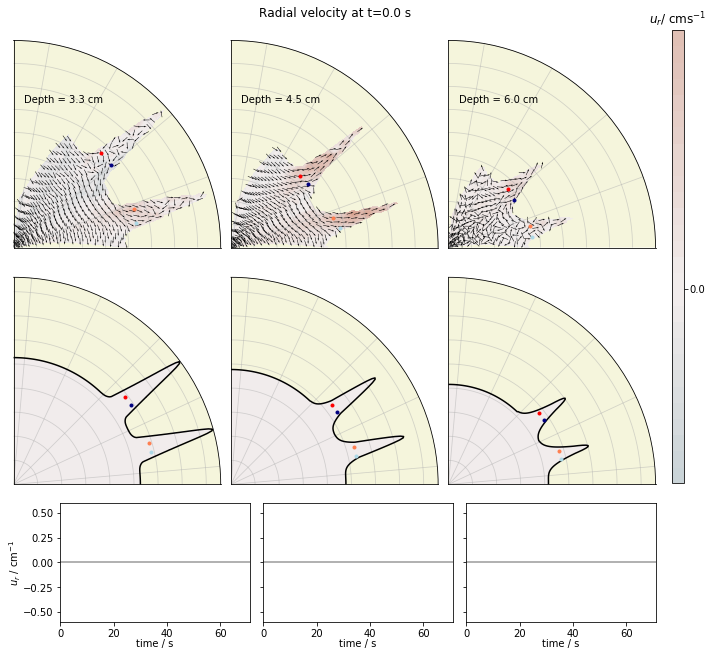

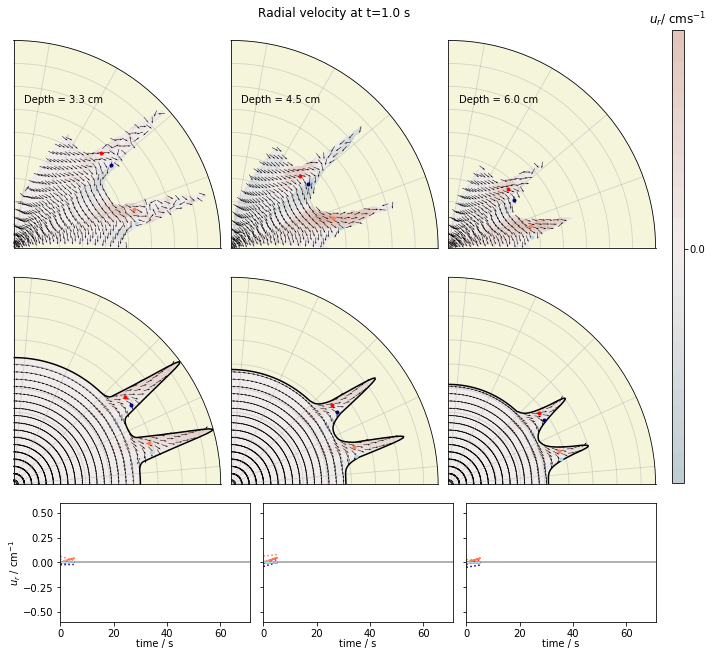

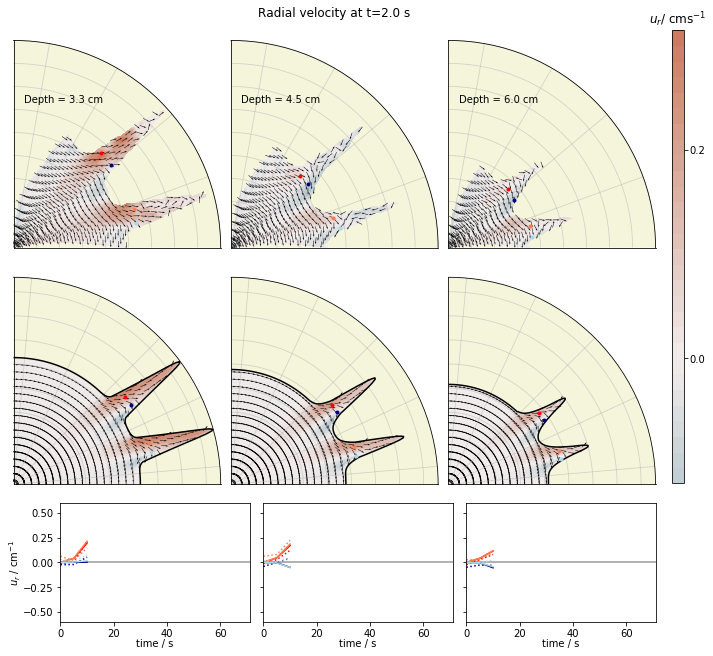

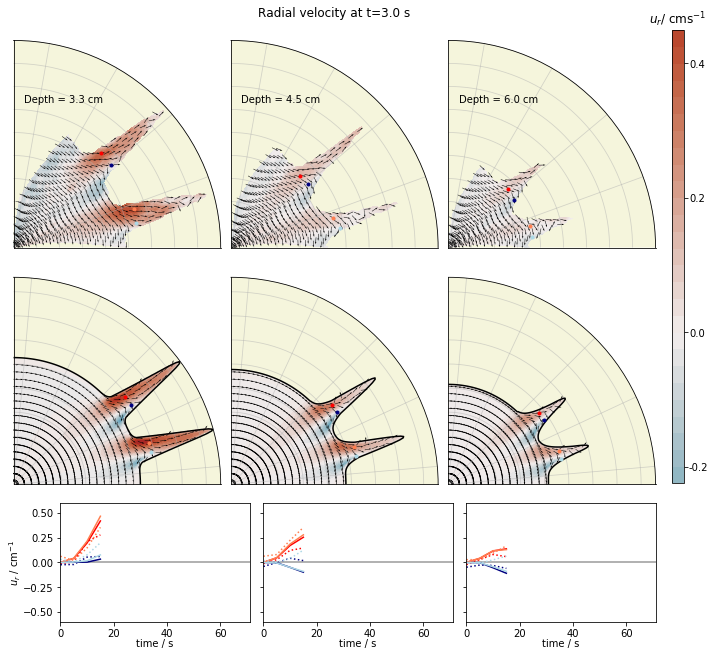

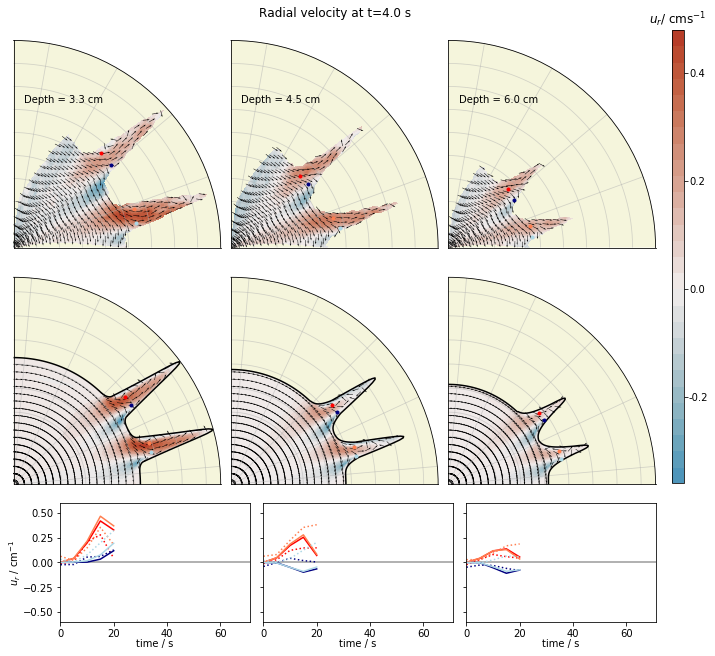

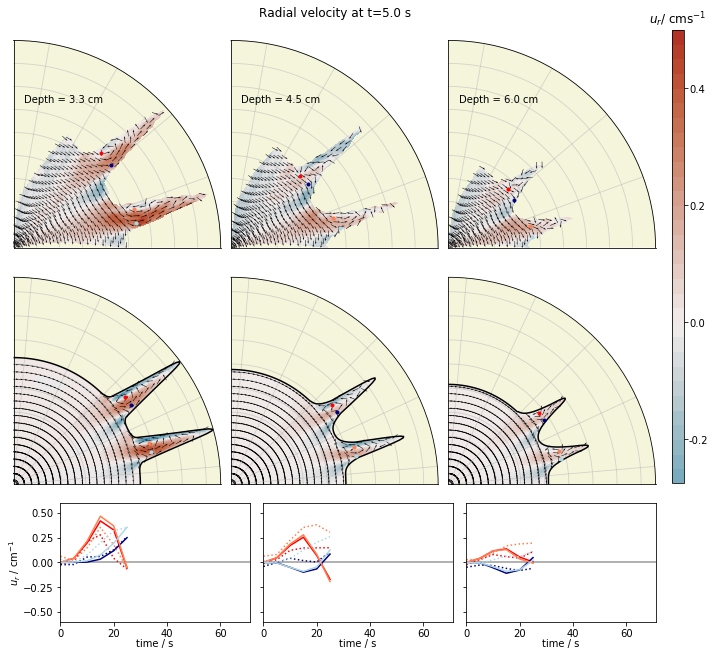

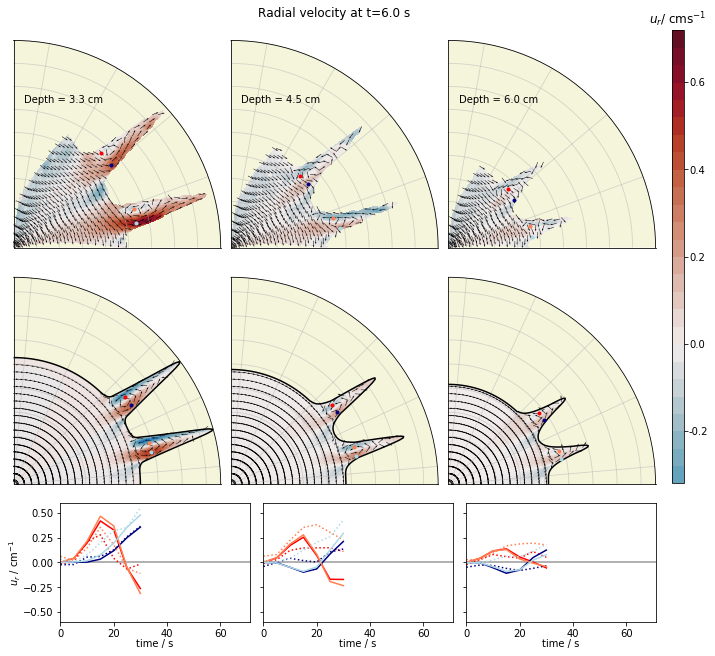

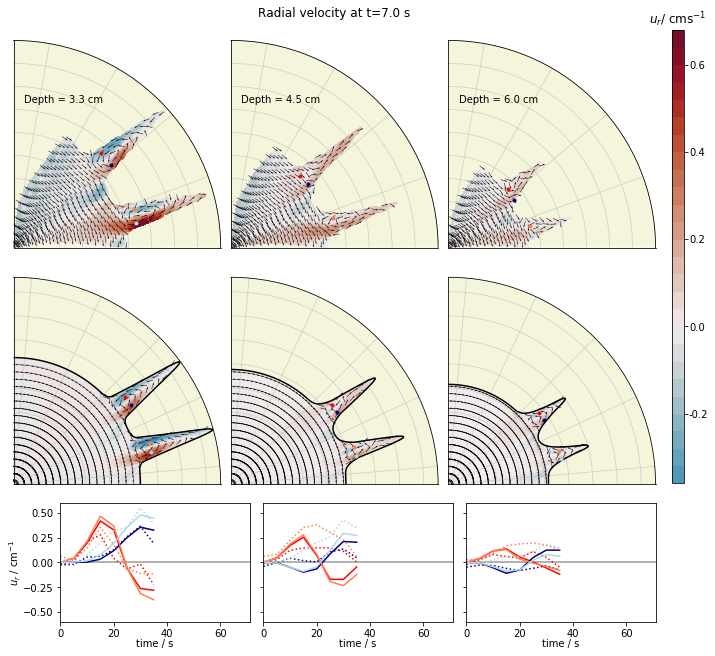

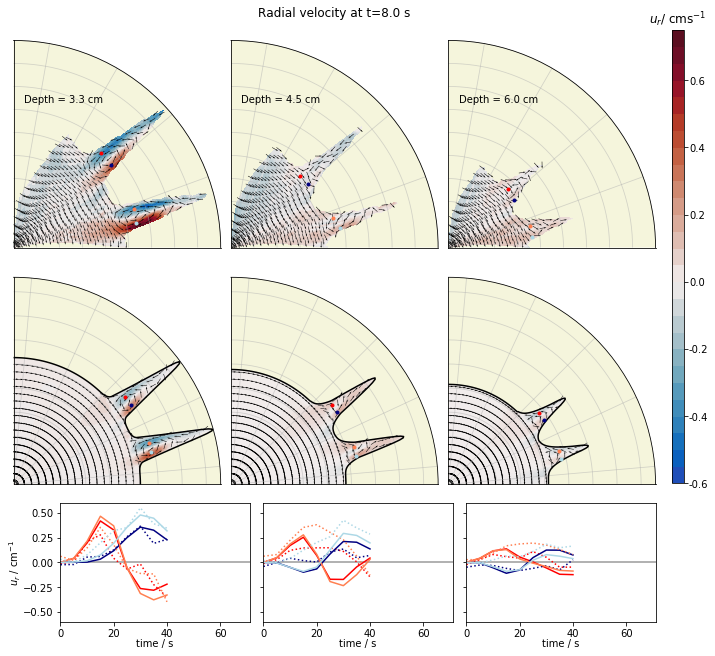

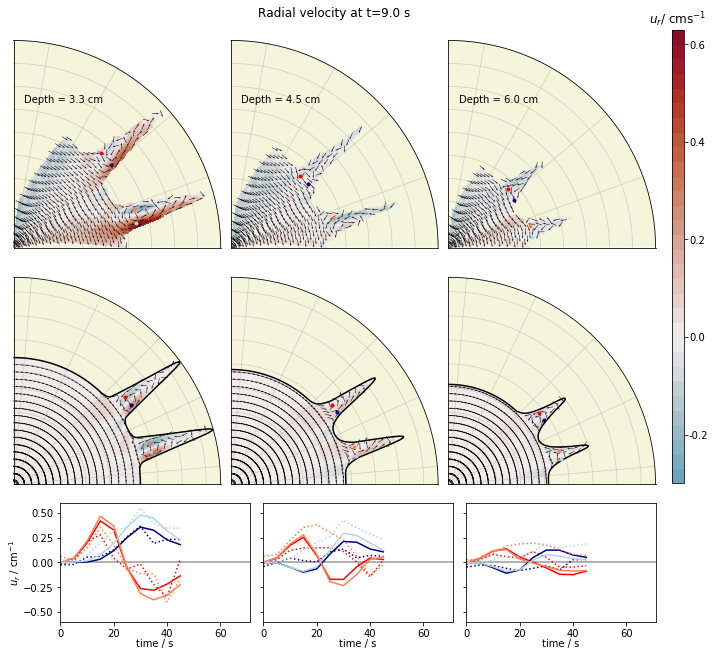

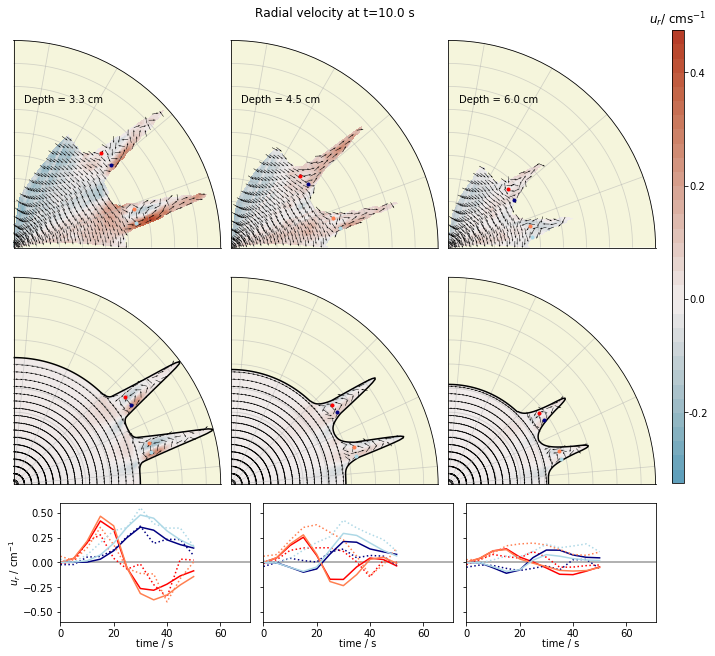

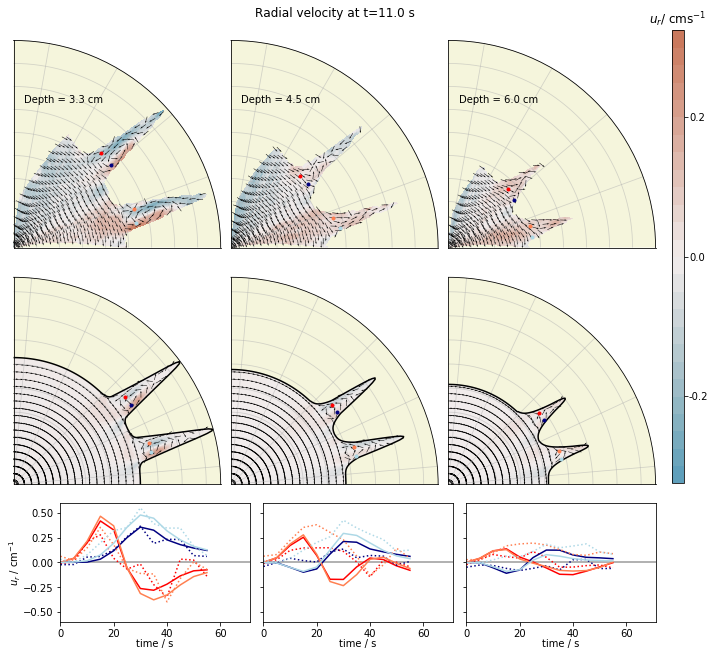

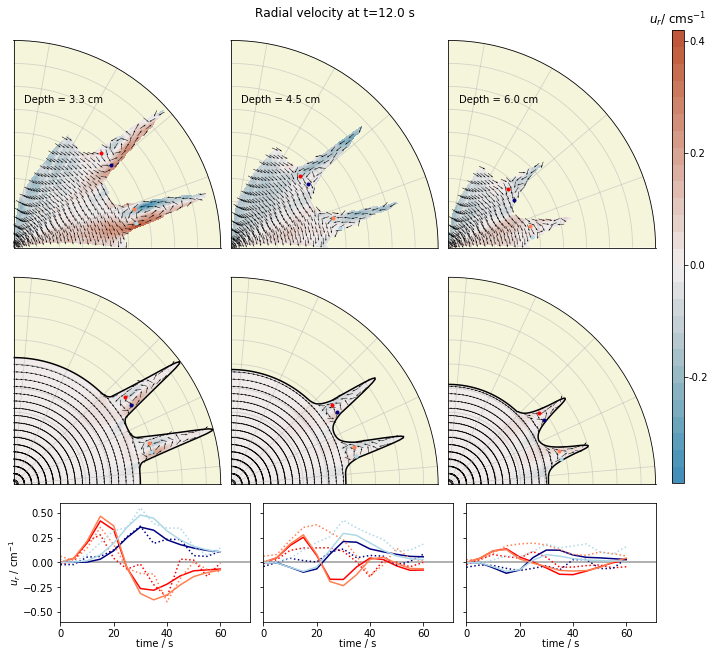

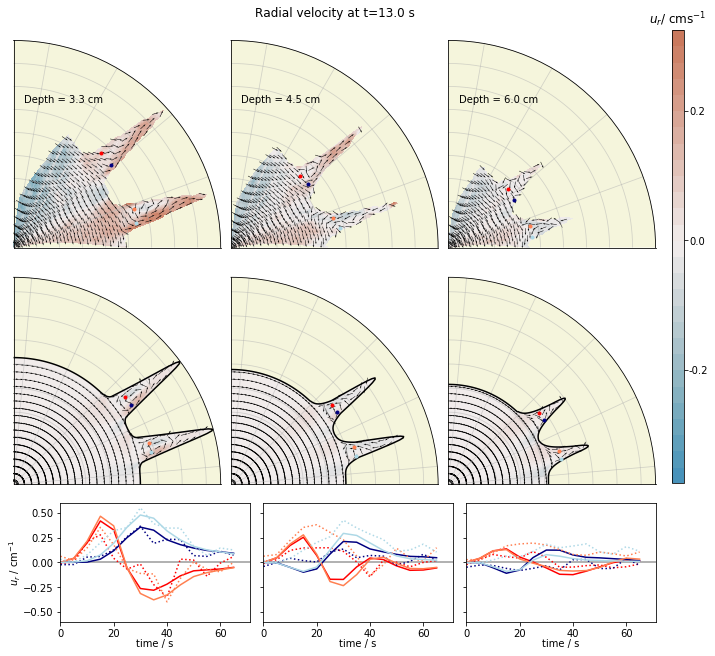

In [219]:
tt = 0

# Formatting 
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False, direction='out',grid_alpha=0.5)
        ax.set_facecolor('beige')
        #ax.grid(False)
 
def make_frame():
    fig = plt.figure(constrained_layout=True, figsize=(9,9))
    gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.9,0.3], hspace=0.0, wspace=0.0)
    gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0], hspace=0.0, wspace=0.0)

    ax1 = fig.add_subplot(gs00[0,0], projection='polar')
    ax2 = fig.add_subplot(gs00[0,1], projection='polar')
    ax3 = fig.add_subplot(gs00[0,2], projection='polar')
    ax4 = fig.add_subplot(gs00[1,0], projection='polar')
    ax5 = fig.add_subplot(gs00[1,1], projection='polar')
    ax6 = fig.add_subplot(gs00[1,2], projection='polar',yticks=[20,25,30])
    gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.5)

    ax7 = fig.add_subplot(gs01[0])
    ax8 = fig.add_subplot(gs01[1])
    ax9 = fig.add_subplot(gs01[2])
    
    fig.suptitle("Radial velocity at t=%1.1f s" %tt)
    format_axes(fig)
    ax7.set_facecolor('white')
    ax7.tick_params(labelbottom=True, labelleft=True)
    ax7.set_ylabel(r'$u_r$ / cm$^{-1}$', labelpad=0)
    ax8.set_facecolor('white')
    ax8.tick_params(labelbottom=True, labelleft=False)
    ax9.set_facecolor('white')
    ax9.tick_params(labelbottom=True, labelleft=False)
    
    return(fig,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9)

# Plotting
# Normalized quivers - lab 5 min avg vel
max_spd =0.8
min_spd = -0.8
cbar_ticks = [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]
nt = 25
frames = np.arange(0,350,nt) # 14 plots

nz1 = int(33/0.5)
nz2 = int(45/0.5)
nz3 = int(60/0.5)
times = np.arange(14) # 14

ur_1 = np.empty(len(times))* np.nan
ur_2 = np.empty(len(times))* np.nan
ur_3 = np.empty(len(times))* np.nan
ur_4 = np.empty(len(times))* np.nan

ur2_1 = np.empty(len(times))* np.nan
ur2_2 = np.empty(len(times))* np.nan
ur2_3 = np.empty(len(times))* np.nan
ur2_4 = np.empty(len(times))* np.nan

ur3_1 = np.empty(len(times))* np.nan
ur3_2 = np.empty(len(times))* np.nan
ur3_3 = np.empty(len(times))* np.nan
ur3_4 = np.empty(len(times))* np.nan

ur_1m = np.empty(len(times))* np.nan
ur_2m = np.empty(len(times))* np.nan
ur_3m = np.empty(len(times))* np.nan
ur_4m = np.empty(len(times))* np.nan

ur2_1m = np.empty(len(times))* np.nan
ur2_2m = np.empty(len(times))* np.nan
ur2_3m = np.empty(len(times))* np.nan
ur2_4m = np.empty(len(times))* np.nan

ur3_1m = np.empty(len(times))* np.nan
ur3_2m = np.empty(len(times))* np.nan
ur3_3m = np.empty(len(times))* np.nan
ur3_4m = np.empty(len(times))* np.nan

for tt, fr, ii in zip(times,frames, range(len(times))):
    fig,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = make_frame()
    
    ax1,ax2,ax3,ur_1[ii],ur_2[ii],ur_3[ii],ur_4[ii],ur2_1[ii],ur2_2[ii],ur2_3[ii],ur2_4[ii],ur3_1[ii],ur3_2[ii],ur3_3[ii],ur3_4[ii] = plot_lab_rad_vel(ax1, ax2, ax3, max_spd, min_spd, cbar_ticks, fr, mode='avg', nt=nt)
    
    ax4,ax5,ax6,ur_1m[ii],ur_2m[ii],ur_3m[ii],ur_4m[ii],ur2_1m[ii],ur2_2m[ii],ur2_3m[ii],ur2_4m[ii],ur3_1m[ii],ur3_2m[ii],ur3_3m[ii],ur3_4m[ii] = plot_model_rad_vel(ax4,ax5,ax6,tt, thmesh, rmesh, nz1, nz2, nz3, min_spd,max_spd, cbar_ticks)
    
    ax7 = plot_ur(ax7,times*5, ur_1m, ur_2m, ur_3m, ur_4m, ur_1, ur_2, ur_3, ur_4, max_time=71)
    ax8 = plot_ur(ax8,times*5, ur2_1m, ur2_2m, ur2_3m, ur2_4m, ur2_1, ur2_2, ur2_3, ur2_4, max_time=71)
    ax9 = plot_ur(ax9,times*5, ur3_1m, ur3_2m, ur3_3m, ur3_4m, ur3_1, ur3_2, ur3_3, ur3_4, max_time=71)
    figname = 'ur_T14_vs_model_%2d.png' %tt
    plt.savefig(figname, format='png', bbox_inches='tight')
    plt.show()